In [1]:
from collections import defaultdict 

import sqlite3 as sql_client
import pandas as pd



from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

import xgboost as xgb
from xgboost import XGBClassifier



## Feature Selection and Data Cleaning

In [2]:
SQL_DB_FILE_PATH='/Users/chin/PycharmProjects/ECE143/FPA_FOD_20170508.sqlite'

causes_map = {
  'Miscellaneous': 0,
  'Lightning': 1,
  'Debris Burning': 2,
  'Campfire': 3,
  'Equipment Use': 4,
  'Arson': 5,
  'Children': 6,
  'Railroad': 7,
  'Smoking': 8,
  'Powerline': 9,
  'Structure': 10,
  'Fireworks': 11,
  'Missing/Undefined': 12
}

connection = sql_client.connect(SQL_DB_FILE_PATH)

In [3]:
cursor = connection.execute('select * from fires')
names = list(map(lambda x: x[0], cursor.description))
print(names)

['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM', 'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID', 'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT', 'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID', 'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME', 'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME', 'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY', 'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE', 'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY', 'FIPS_CODE', 'FIPS_NAME', 'Shape']


In [4]:
query = """
    SELECT
      latitude,
      longitude,
      fire_size as size,
      strftime('%w', discovery_date) as day_of_week,
      strftime('%m', discovery_date) as month,
      fire_year as year,
      CONT_TIME as burn_time,
      STATE as state,
      stat_cause_descr as cause
    FROM fires
    LIMIT 50000
    """


In [5]:
df = pd.read_sql(query, con=connection)
df = df.rename(columns={"STAT_CAUSE_DESCR": "cause"})
df['cause'] = df['cause'].map(causes_map)
df = df.dropna()
print(df.columns)
print(df.head)

Index(['LATITUDE', 'LONGITUDE', 'size', 'day_of_week', 'month', 'year',
       'burn_time', 'state', 'cause'],
      dtype='object')
<bound method NDFrame.head of         LATITUDE   LONGITUDE  size day_of_week month  year burn_time state  \
0      40.036944 -121.005833  0.10           3    02  2005      1730    CA   
1      38.933056 -120.404444  0.25           3    05  2004      1530    CA   
2      38.984167 -120.735556  0.10           1    05  2004      2024    CA   
3      38.559167 -119.913333  0.10           1    06  2004      1400    CA   
4      38.559167 -119.933056  0.10           1    06  2004      1200    CA   
...          ...         ...   ...         ...   ...   ...       ...   ...   
49995  42.825000 -120.906667  2.00           5    08  1992      1200    OR   
49996  42.943333 -121.221667  0.10           5    08  1992      2243    OR   
49997  42.986667 -120.808333  0.20           5    08  1992      0200    OR   
49998  43.188333 -121.201667  0.10           6    08  199

### Feature Engineering on State

In [6]:
d = defaultdict(int)
idx = 0
for x in df['state']:
    if x in d: continue
    d[x] = idx
    idx += 1
df['state'] = df['state'].replace(d)

In [7]:
def train_xgb(data):
    X = data.drop(['cause'], axis=1).values
    Y = data['cause'].values
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=0)
    xgb = XGBClassifier(n_estimators=300)
    xgb.fit(X_train, y_train)
    preds = xgb.predict(X_test)
    acc_xgb = (preds == y_test).sum().astype(float) / len(preds)*100
    print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))


In [54]:
def grid_search(data):
    data = data.dropna()
    X = data.drop(['cause'], axis=1).values
    Y = data['cause'].values
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=0)
    clf = xgb.XGBClassifier()
    parameters = {
#          "eta"    : [0.05, 0.15, 0.25 ] ,
         "max_depth"        : [ 3, 5, 7],
         "min_child_weight" : [ 1, 3, 5 ],
         "gamma"            : [ 0.0, 0.1, 0.2],
         "colsample_bytree" : [ 0.3, 0.5 , 0.7 ]
    }
    grid = GridSearchCV(clf,
                        parameters, n_jobs=4,
                        scoring="neg_log_loss",
                        cv=3,
                       verbose = 2)

    grid.fit(X_train, y_train)
    return grid

### Vanilla Random Forest

In [86]:
def rf_clf(data_frame):
    data_frame = data_frame.dropna()
    X = data_frame.drop(['cause'], axis=1).values
    Y = data_frame['cause'].values
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=0) # 80% to train; 20% test
    classifier = RandomForestClassifier(n_estimators=300, random_state=42)
    classifier.fit(X_train, Y_train)
    score = classifier.score(X_test, Y_test) * 100
    print('Test Set Score: {} %'.format(score))

### Best Fit Random Forest

In [7]:
def rf_clf_best(data_frame):
    data_frame = data_frame.dropna()
    X = data_frame.drop(['cause'], axis=1).values
    Y = data_frame['cause'].values
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=0) # 80% to train; 20% test
    classifier = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
    classifier.fit(X_train, Y_train)
    score = classifier.score(X_test, Y_test) * 100
    print('Test Set Score: {} %'.format(score))
    return classifier

### Grid Search

In [99]:
def rf_gridsearch(data):
    data = data.dropna()
    X = data.drop(['cause'], axis=1).values
    Y = data['cause'].values
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=0)
    n_estimators = [200, 300]
    max_depth = [5, 15, None]
    max_features = ['auto', 'sqrt', 'log2']
    criterion = ['gini', 'entropy']

    hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              max_features = max_features, criterion = criterion)
    forest = RandomForestClassifier(random_state=42)
    gridF = GridSearchCV(forest, hyperF, cv = 5, verbose = 2, 
                      n_jobs = 4)
    bestF = gridF.fit(X_train, y_train)
    return bestF

In [98]:
# Without State
rf_clf(df.drop(['state'], axis=1))

# With State
rf_clf(df)

Test Set Score: 69.95888900030081 %
Test Set Score: 70.22961997392962 %


In [100]:
# Grid Search
bestF = rf_gridsearch(df)
print(bestF.best_estimator_)


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 11.2min
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed: 14.8min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


In [8]:
clf = rf_clf_best(df)

Test Set Score: 70.39005314348742 %


## Confusion Matrix

Confusion matrix, without normalization
[[ 425  406   68  144   48  121    5    1    3]
 [  75 5286   16  119    6   40    0    0    0]
 [ 113   85  141   46    5  106    0    0    1]
 [ 124  527   21  608    5   33    1    0    6]
 [  87  118   19   32   70   21    0    0    1]
 [  87   93   48   37    7  480    1    0    2]
 [  18   40    4    9    4    7    0    0    0]
 [   5   17    4    5    0    9    0    4    0]
 [  30   63    3   47    1    9    0    0    6]]
Normalized confusion matrix
[[3.48075348e-01 3.32514333e-01 5.56920557e-02 1.17936118e-01
  3.93120393e-02 9.90990991e-02 4.09500410e-03 8.19000819e-04
  2.45700246e-03]
 [1.35330206e-02 9.53807290e-01 2.88704439e-03 2.14723926e-02
  1.08264165e-03 7.21761097e-03 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [2.27364185e-01 1.71026157e-01 2.83702213e-01 9.25553320e-02
  1.00603622e-02 2.13279678e-01 0.00000000e+00 0.00000000e+00
  2.01207243e-03]
 [9.35849057e-02 3.97735849e-01 1.58490566e-02 4.58867925e-01
  3.7735849

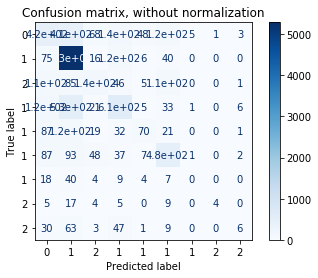

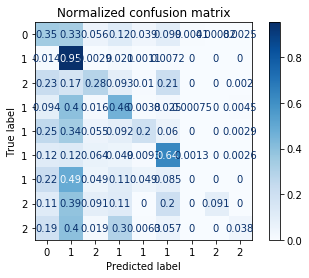

In [113]:
def confusion_matrix(clf, data):
    data = data.dropna()
    X = data.drop(['cause'], axis=1).values
    Y = data['cause'].values
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=0)
    titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(clf, X_test, y_test,
                                     display_labels=data['cause'],
                                     cmap=plt.cm.Blues,
                                     normalize=normalize)
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)

    plt.show()
    
confusion_matrix(clf, df)

[[ 425  406   68  144   48  121    5    1    3]
 [  75 5286   16  119    6   40    0    0    0]
 [ 113   85  141   46    5  106    0    0    1]
 [ 124  527   21  608    5   33    1    0    6]
 [  87  118   19   32   70   21    0    0    1]
 [  87   93   48   37    7  480    1    0    2]
 [  18   40    4    9    4    7    0    0    0]
 [   5   17    4    5    0    9    0    4    0]
 [  30   63    3   47    1    9    0    0    6]]


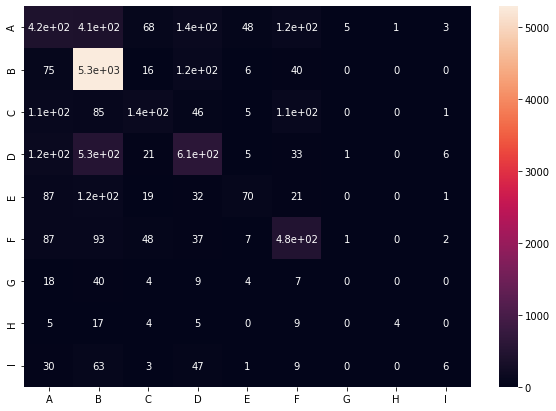

In [15]:
import seaborn as sn
def plot(clf, data):
    data = data.dropna()
    X = data.drop(['cause'], axis=1).values
    Y = data['cause'].values
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=0)
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    df_cm = pd.DataFrame(cm, index = [i for i in "ABCDEFGHI"],
                      columns = [i for i in "ABCDEFGHI"])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
    plt.show()

plot(clf, df)